# Tutorial on the Reproduction of selected Articles

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/dehe1011/QuantumDNA-notebooks/blob/main/tutorials/Reproduce.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

# Save flag: Set to True to enable saving results (currently unused in this script)
save = False

# Verbose flag: Set to True to enable detailed logging
verbose = False

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Installation of QuantumDNA
# --------------------------

from importlib.util import find_spec

qDNA_installed = find_spec('qDNA') is not None

if not qDNA_installed:
    %pip install qDNA
    print("Successfully installed the 'qDNA' package.")
else:
    print("Package 'qDNA' is already installed.")

if verbose:
    %pip show qDNA  

from qDNA import * 

# ------------------------
# Directory Setup
# ------------------------

import os

# Use the current working directory as the root
ROOT_DIR = os.getcwd()

# Define directories to load data
DATA_DIR = os.path.join(ROOT_DIR, "data")
os.makedirs(DATA_DIR, exist_ok=True)

# Define directory to save figures
SAVE_DIR = os.path.join(DATA_DIR, "my_figures")
os.makedirs(SAVE_DIR, exist_ok=True)

if verbose:
    print(f"Data directory: '{DATA_DIR}' is ready.")
    print(f"Save directory: '{SAVE_DIR}' is ready.")

Package 'qDNA' is already installed.


## Giese 1999 and Simserides 2014

[1] B. Giese et al., Angew. Chem. Int. Ed. **38**, 996 (1999)

[2] C. Simserides, Chemical Physics **440**, 31 (2014)

In [3]:
# Giese experiment: eta = 1.7, beta = 0.07

kwargs = dict(tb_model_name = 'WM', description='1P', particles=['hole'], unit='rad/fs', relaxation=False, source='Simserides2014')

GGG_per_G = []
for num_steps in np.arange(1, 9):
    bridge = 'TT' + 'GTT' * (num_steps-1)
    upper_strand = 'ACGCACGTCGCATAATATTAC' + 'G' + bridge + 'GGG' + 'TATTATATTACGC'
    tb_sites = get_tb_sites(upper_strand, tb_model_name='WM')
    tb_ham = TBHam(tb_sites, **kwargs)
    
    donor_site = '(0, 21)' # guanine left from the bridge    
    acceptor_sites = [f'(0, {21+len(bridge)+1})', f'(0, {21+len(bridge)+2})',  f'(0, {21+len(bridge)+3})']

    donor_avg_pop = tb_ham.get_average_pop(donor_site, donor_site)['hole']
    acceptor_avg_pop = 0
    for acceptor_site in acceptor_sites:
        acceptor_avg_pop += tb_ham.get_average_pop(donor_site, acceptor_site)['hole']

    GGG_per_G_ratio = acceptor_avg_pop / donor_avg_pop 
    GGG_per_G.append(GGG_per_G_ratio)

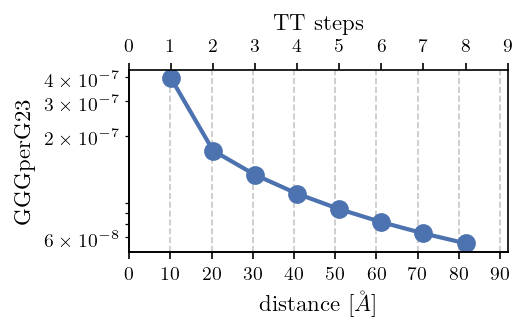

In [7]:
fig, ax = plt.subplots()

colors = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]

ax.plot(np.arange(1, 9) * 3 * 3.4, np.array(GGG_per_G)/(2*np.pi), 'o-', color=colors[0])

top_ticks = np.arange(0,100,10)
top_labels = np.arange(0,100,10)
ax.set_xticks(top_ticks)
ax.set_xticklabels(top_labels)

ax.set_yscale('log')
ax.set_xlim(0, 9*3*3.4)
ax.set_xlabel(r'distance [$\AA$]')
ax.set_ylabel('GGGperG23')

ax2 = ax.twiny()
# ax2.plot(np.arange(1, 9), np.array(ratio_list)/(2*np.pi) * np.e**2, 'o-', color=colors[1] )

ax2.set_xlabel(r'TT steps')
top_ticks = np.arange(0, 10)
top_labels = np.arange(0, 10) 
ax2.set_xticks(top_ticks)
ax2.set_xticklabels(top_labels)

ax.set_yticks([])
ax2.set_yticks([])
ax.set_yticklabels([])
ax2.set_yticklabels([])

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.grid(True)

if save:
    fig_filename = input("Filename for Saving: ")
    plt.savefig(os.path.join(SAVE_DIR, fig_filename + '.pdf'))

## Giese 2001 and Simserides 2014

[1] B. Giese, Nature **412**, 318 (2001)

[2] C. Simserides, Chemical Physics **440**, 31 (2014)

In [8]:
# experiment: beta = 0.6 
# theory: beta = 0.8, beta = 0.07

def calc_difference(upper_strand, t):
    """ t in fs. """
    tb_sites = get_tb_sites(upper_strand, tb_model_name='WM')
    tb_ham = TBHam(tb_sites, tb_model_name='WM', description='1P', particles=['hole'], relaxation=False, source='Simserides2014')
    difference = 0
    acceptor_sites = [f'(0, {len(bridge)+1})', f'(0, {len(bridge)+2})', f'(0, {len(bridge)+3})']
    for acceptor_site in acceptor_sites:
        amplitudes_dict, frequencies_dict, average_pop_dict = tb_ham.get_fourier('(0, 0)', acceptor_site, ["amplitude", "frequency", "average_pop"])
        amplitudes, frequencies, average_pop = amplitudes_dict['hole'], frequencies_dict['hole'], average_pop_dict['hole']
        difference += average_pop - get_pop_fourier(t, average_pop, amplitudes, frequencies)
    return average_pop, difference


def calc_t_mean(upper_strand, t_max, t_min=0, t_step=1): 
    for t in range(t_min, t_max, t_step):
        average_pop, difference = calc_difference(upper_strand, t)
        if difference <= 0:
            return average_pop, t
    return average_pop, f"Mean population not reached in {t_max} fs"

t_mean_list, average_pop_list, transfer_rate_list = [], [], []
t_min_list = [2000, 32000, 225000, 250000, 140000, 3000, 0, 1000, 4000, 1000, 0, 1000, 4000, 3000, 3000, 1000]
t_steps_list = [1, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

for i, num_T in enumerate(np.arange(1,17)):
    bridge = 'T' * num_T
    upper_strand = 'G' + bridge + 'GGG' + 'TATTATATTACGC'
    average_pop, t_mean = calc_t_mean(upper_strand, 10_000_000, t_min=t_min_list[i], t_step=t_steps_list[i])
    average_pop_list.append(average_pop)
    t_mean_list.append(t_mean)
    transfer_rate_list.append(average_pop/t_mean)

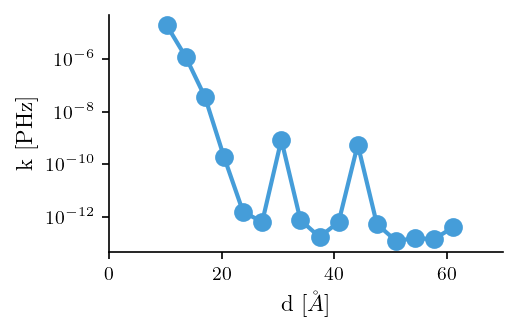

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(np.arange(3, 19)*3.4, np.array(transfer_rate_list)/(2*np.pi), 'o-')
ax.set_yscale('log')
ax.set_xlim(0, 70)
ax.set_xlabel(r'd [$\AA$]')
ax.set_ylabel('k [PHz]')

if save:
    fig_filename = input("Filename for Saving: ")
    plt.savefig(os.path.join(SAVE_DIR, fig_filename + '.pdf'))

## Bittner 2006 & 2007

[1] E. Bittner, The Journal of Chemical Physics **125**, 094909 (2006)

[2] E. Bittner, Journal of Photochemistry and Photobiology A: Chemistry **190**, 328 (2007)

In [28]:
tb_sites = get_tb_sites('AAAAA')
kwargs = dict(tb_model_name='ELM', source='Bittner2007', unit='eV', relaxation=False, coulomb_interaction=2.5, 
              exchange_interaction=1, init_e_states=['(0, 2)'], init_h_states=['(0, 2)'], t_end=300, t_unit='fs', t_steps=300)
vis = Visualization(tb_sites, **kwargs)

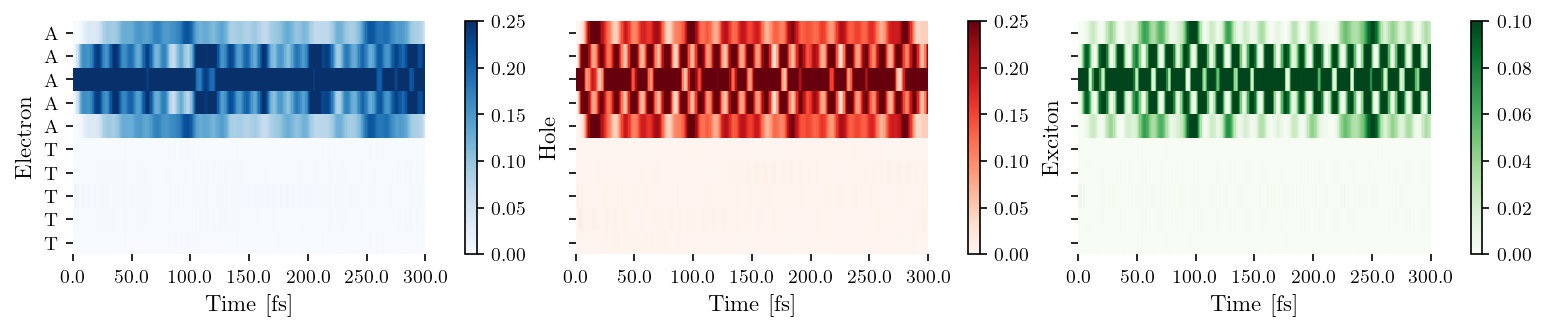

In [29]:
fig, ax = vis.plot_heatmap(heatmap_type='seaborn', vmax_list=[0.25, 0.25, 0.1])

if save:
    fig_filename = input("Filename for Saving: ")
    plt.savefig(os.path.join(SAVE_DIR, fig_filename + '.pdf'))

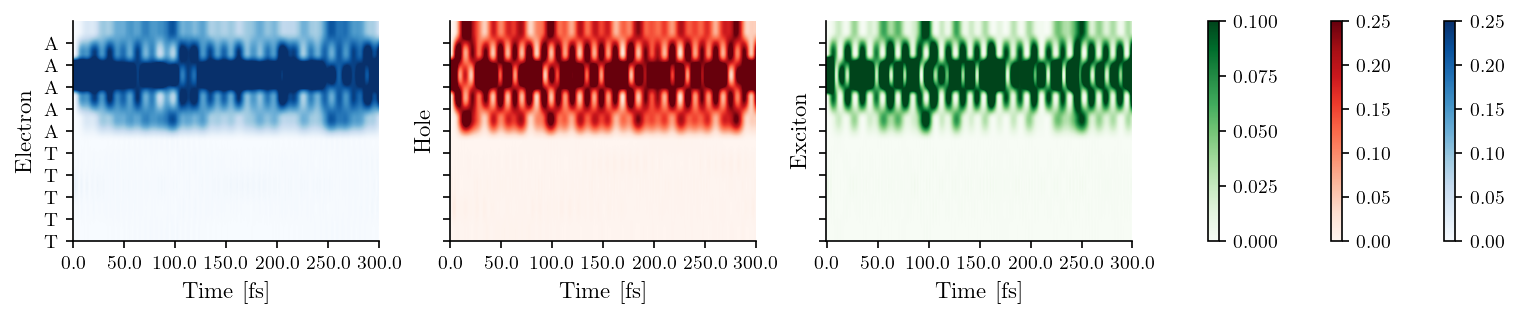

In [30]:
fig, ax = vis.plot_heatmap(heatmap_type='matplotlib', vmax_list=[0.25, 0.25, 0.1])

if save:
    fig_filename = input("Filename for Saving: ")
    plt.savefig(os.path.join(SAVE_DIR, fig_filename + '.pdf'))

## Mantela 2023

[1] M. Mantela, Phys. Chem. Chem. Phys. **25**, 7750 (2023)

In [27]:
filenames = ["A1", "c1'", "A2", "c2'"]

mono_list = []
for filenames in [["A1", "c1'"], ["A2", "c2'"]]:
    filepaths =  [os.path.join(DATA_DIR, "my_geometries", "Mantela", filename+'.xyz') for filename in filenames]
    mono_list.append( Monomer(filepaths, param_id='MSF') )

mono1, mono2 = mono_list[0], mono_list[1]
t_EXC = calc_dipolar_coupling(mono1, mono2)
lcao_param = load_lcao_param('MSF')
H_inter = calc_H_inter(lcao_param, mono1, mono2)
t_HOMO = mono1.HOMO @ H_inter @ mono2.HOMO
t_LUMO = mono1.LUMO @ H_inter @ mono2.LUMO

print("TB parameters")
print(f"E_HOMO_A: {mono1.E_HOMO}", f"E_LUMO_A: {mono1.E_LUMO}")
print(f"E_HOMO_B: {mono2.E_HOMO}", f"E_LUMO_B: {mono2.E_LUMO}")
print(f"t_HOMO: {t_HOMO}", f"t_LUMO: {t_LUMO}", f"t_EXC: {t_EXC}")    

TB parameters
E_HOMO_A: -8.429037928082417 E_LUMO_A: -4.4328918423210375
E_HOMO_B: -8.430148205528658 E_LUMO_B: -4.432672724825064
t_HOMO: -0.03594025742542862 t_LUMO: -0.09015171853086548 t_EXC: 0.003424120294543702
